In [181]:
import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv

#Fashion-MNIST classes (mapping from class index to class name)
class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# some utilities

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

        
def read_fMNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_fMNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.axis('off')
    pyplot.show()

Let's look at some images

Training images
Class: bag


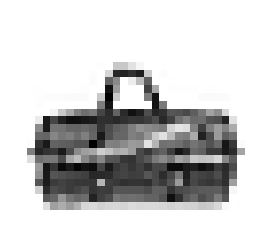

Class: shirt


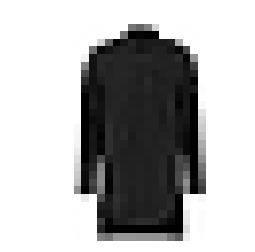

Validation images
Class: bag


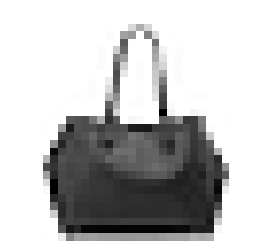

Class: sandal


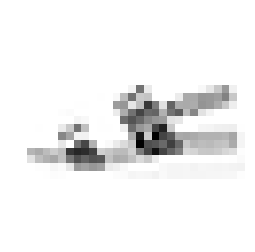

In [182]:

X,y = read_fMNIST('training')
print('Training images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])


X,y = read_fMNIST('validation')
print('Validation images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])



Now we will build the code for our softmax model

In [183]:
from scipy.sparse import csr_matrix 
import pdb

def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapont with d features
      Y: a Nx10 matrix, each row is a one-hot vector with the ith entry is 1 if that datapoint belongs to class i 
      w: is a dx10 matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #compute the un-normalized 'scores' of each class for each datapoint
    scores = infer(X,w)
    
    #normalize the scores to get a distribution over classes for each datapointns 
    predictions = softmax(scores) #n x 10 
    
    #pdb.set_trace()
    #Use the predicted distributions, and the true distributions to compute log-likelihood
    y_indices = y.astype(bool)
    log_probs = np.log( predictions[y_indices] ) #nx1 
    LL = np.mean(log_probs)

    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro')
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer



def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    #Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    predictions = softmax(scores)

    #Compute the gradient of the average log-loss
    grad = np.dot(np.transpose( X ), predictions - y )
    
    l2grad = grad + 2*w
    
    return grad, l2grad

def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores

def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc
        

Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [184]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1],yTr.shape[1]))
    
    old_obj = 1e9  
    old_w = w
    
    # we will organize the run in terms of epochs (one epcoh = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)
    
    for epoch in range(maxepochs):
        
        #shuffle the data
        index = np.random.permutation(xTr.shape[0])
        nBatches = np.floor(xTr.shape[0]/bsize).astype(np.integer) # ignore the remainder N-floor(N/bsize), for simplicity
    
        for b in range(nBatches):
            # fill in the batch
            iBatch = index[b*bsize:(b+1)*bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]
            
            grad,l2grad = gradient(xBatch,w,yBatch)
    
            w = w-lr*(grad+lmbda*l2grad)
            
        
        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr,w,yTr)
        obj[epoch] = logloss+lmbda*regularizer
                
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr,w,yTr)

        obj_gain = (old_obj-obj[epoch])/np.abs(old_obj) # improvement in training objective this epich
        
        if verbose > 0.5:
            print('Epoch %d: obj=%.4f, gain %.4f  [train acc %.4f]'%(epoch,obj[epoch],obj_gain,trAcc[epoch]))
        
        
        if epoch == maxepochs-1:
            if verbose > 0:
                print('Reached max epochs, stopping')
            return w, obj, trAcc
        
        if obj_gain < objTol:  
            lr = lr/2
            if verbose > 0:
                print('Dropping learning rate to %.4f'%lr)
        
        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]    
    

Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [185]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X,mu = None,sigma = None,visualize=False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)]=1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X-mu)/sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if compute_stats:
        return X, mu, sigma
    else:
        return X




VISUALIZE BEFORE NORMALIZATION


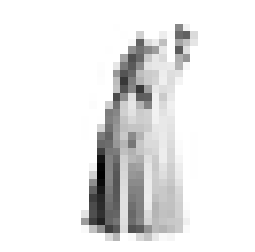

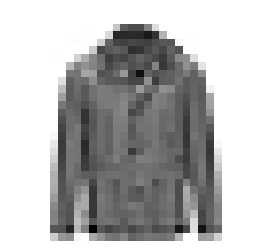

VISUALIZE AFTER NORMALIZATION


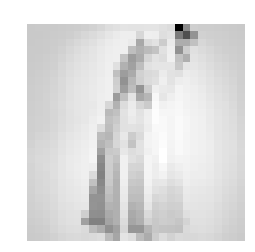

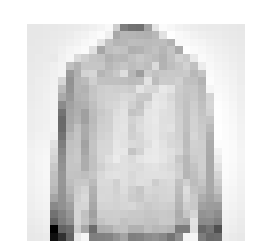

In [186]:
xTr, yTr = read_fMNIST('Training')
xTr, mu, sigma = preprocess_data(xTr,visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [187]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt):
    
    obj=dict()
    trAcc=dict()
    model=dict()
    valAcc=dict()

    for lmbda in lambdas:
        model[lmbda], obj[lmbda],trAcc[lmbda] = minibatch_sgd(xTr,yTr,xVl,yVl,lmbda, sgd_opt['lr'],sgd_opt['maxepochs'],sgd_opt['bsize'],verbose=sgd_opt['verbose'])
        valAcc[lmbda] = accuracy(xVl,model[lmbda],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,valAcc[lmbda],trAcc[lmbda][-1]))
        
    return model, obj, trAcc, valAcc

In [188]:
xTr, yTr = read_fMNIST('Training')
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

# values below are a recommendation for initial exploration -- you should see if you want to refine these

lambdas = [0.005, .008, .01, 0.02, 0.05, 0.1]
sgd_opt = {'bsize':16, 'maxepochs':25, 'lr':.1,'verbose':0}

    
#10 - 40, #16 - 26, 0.1 - 0.2 

model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)


-------------- lambda=0.00500, val Acc = 0.8501  (tr Acc = 0.8808)
-------------- lambda=0.00800, val Acc = 0.8518  (tr Acc = 0.8780)
-------------- lambda=0.01000, val Acc = 0.8458  (tr Acc = 0.8728)
-------------- lambda=0.02000, val Acc = 0.8533  (tr Acc = 0.8754)
-------------- lambda=0.05000, val Acc = 0.8518  (tr Acc = 0.8678)
-------------- lambda=0.10000, val Acc = 0.8521  (tr Acc = 0.8644)


After experimenting with some values of lambda, we narrowed down the initial range to [.008, .01, 0.02, 0.05, 0.1, 0.2], along with changing the batch size and maxexpochs (Again after experimentation.) 

In [189]:
#*************** write code to select best model
def get_best_mdl_index(valAcc):
    '''
    params: 
        valAcc - dictionary of lists representing the accuracy 
    returns: 
        int - best lambda 
    '''
    keys = list( valAcc.keys() )
    max_acc = 0
    max_lambda = keys[0]
    for k in keys: 
        if valAcc[k] > max_acc: 
            max_acc = valAcc[k]
            max_lambda = k 
            
    return max_lambda  

Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)

In [190]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)

#Decide which model you want to use for your submission
best = get_best_mdl_index(valAcc)
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./large_submission.csv', final_preds)

Now we will repeat this experiment with the small training set

Choice of tuning parameters: here we only experimented with different values of lamba (it doesnt take many epochs for convergence due to the size of the dataset. We ultimately settle for the range [0.1, 0.5, 1, 2, 4, 8, 16].  

In [191]:
xTr, yTr = read_fMNIST('Training', load_small=True)
xVl, yVl = read_fMNIST('Validation')


xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0.1, 0.5, 1, 2, 4, 8, 16]
sgd_opt_small = {'bsize':3, 'maxepochs':30, 'lr':.1,'verbose':0}


model_small, obj_small, trAcc_small, valAcc_small = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt_small)

# *************** code to select best model
#see my function above 

-------------- lambda=0.10000, val Acc = 0.5829  (tr Acc = 1.0000)
-------------- lambda=0.50000, val Acc = 0.5843  (tr Acc = 1.0000)
-------------- lambda=1.00000, val Acc = 0.5732  (tr Acc = 1.0000)
-------------- lambda=2.00000, val Acc = 0.5718  (tr Acc = 1.0000)
-------------- lambda=4.00000, val Acc = 0.5714  (tr Acc = 1.0000)
-------------- lambda=8.00000, val Acc = 0.5623  (tr Acc = 1.0000)
-------------- lambda=16.00000, val Acc = 0.5441  (tr Acc = 1.0000)


In [192]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
best_small = get_best_mdl_index(valAcc_small)
chosen_model = model_small[best_small]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./small_submission.csv', final_preds)


# The training accuracy

In [193]:
n = sgd_opt['maxepochs']
print("The training accuracy for the large training dataset: {}".format(trAcc[best][n-1]))
n_small = sgd_opt_small['maxepochs']
print("The training accuracy for the small training dataset: {}".format(trAcc_small[best_small][n - 1]))

The training accuracy for the large training dataset: 0.87542
The training accuracy for the small training dataset: 1.0


# The validation accuracy

In [194]:
print("The val accuracy for the large training dataset: {}".format(valAcc[best]))
print("The val accuracy for the small training dataset: {}".format(valAcc_small[best_small]))

The val accuracy for the large training dataset: 0.8533
The val accuracy for the small training dataset: 0.5843


# The confusion matrix

Note that the true classes are on the top and the predicted class is on the left. 

In [195]:
from sklearn.metrics import confusion_matrix

def prod_confusion_matrix(X, w, y): 
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    print(confusion_matrix(y, y_hat))

xTr, yTr = read_fMNIST('Training')
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

print("Confusion Matrix for Large Data set: ")
prod_confusion_matrix(xVl, chosen_model, yVl)

xTr, yTr = read_fMNIST('Training', load_small=True)
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

print("\n\nConfusion Matrix for Small Data set: ")
prod_confusion_matrix(xVl, model_small[best_small], yVl)

Confusion Matrix for Large Data set: 
[[688   7  21  92  38  47  41   0   6   3]
 [ 28 889   5  18  10   4  19   0   0   0]
 [ 17   6 444   2 199 154 203   0   7   6]
 [146  87   4 550 132  58  15   0   1   0]
 [ 16  12 196   4 584  95 103   0   5   4]
 [  0   0   0   0   0 723   0 227   0  50]
 [218   3 162  27 178 191 221   0  16   4]
 [  0   0   0   0   0  81   0 912   4  19]
 [ 74   2  23  14  45 102  41  64 631  24]
 [  1   0   0   0   1  79   0 250   4 643]]


Confusion Matrix for Small Data set: 
[[655   7  49  83  25  53  61   3   7   0]
 [ 25 888  15  14   8   2  21   0   0   0]
 [ 16   5 425   2 175 157 249   0   9   0]
 [137 110  15 511 127  71  20   0   2   0]
 [ 14  15 181   2 577 100 124   1   5   0]
 [  3   0   5   0   0 670   3 283   5  31]
 [197   2 168  26 161 193 254   5  14   0]
 [  0   0   0   0   0  75   0 921   9  11]
 [ 64   2  27  11  37  90  54 227 488  20]
 [  2   1  40   0   0 119   1 259 102 454]]


# Visualize the parameters 

For the small model:

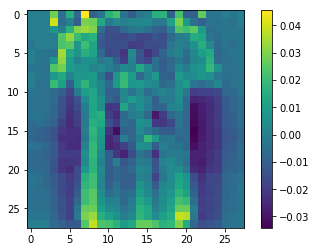

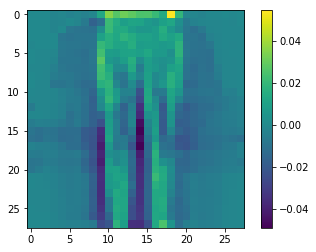

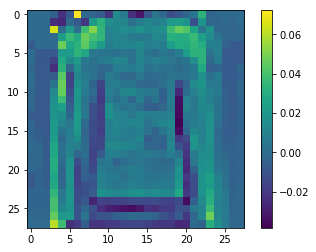

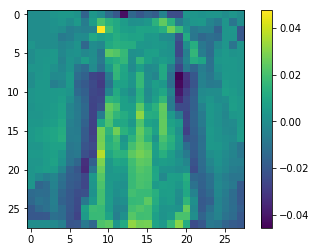

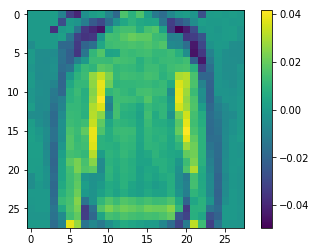

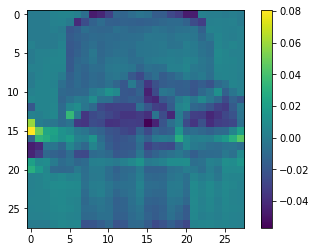

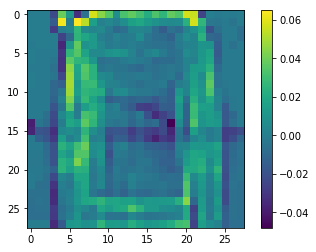

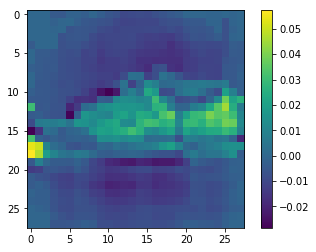

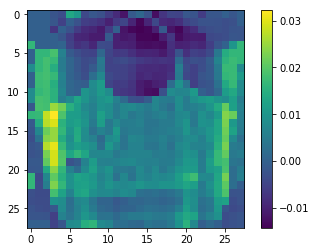

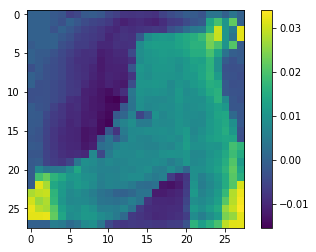

In [196]:
for c in range(10): 
    plt.imshow(model_small[best_small][-28**2:, c].reshape(28, 28))
    plt.colorbar()
    plt.show()

For the large model: 

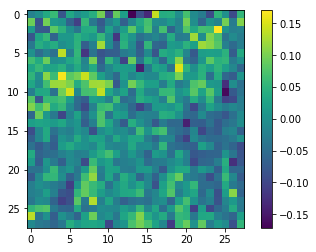

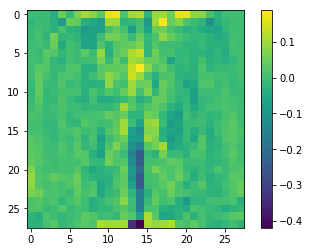

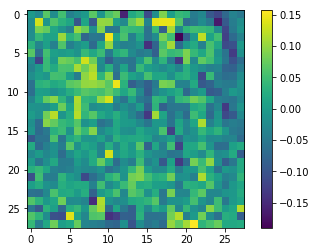

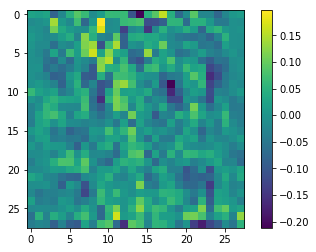

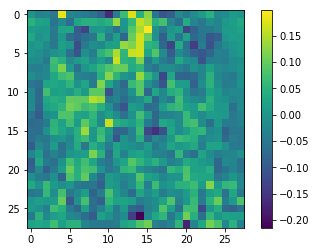

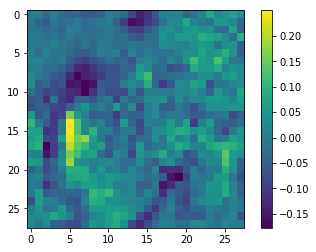

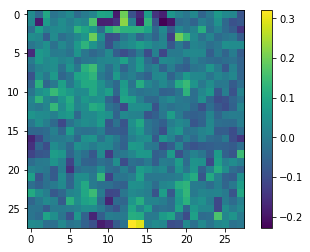

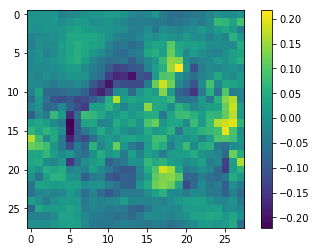

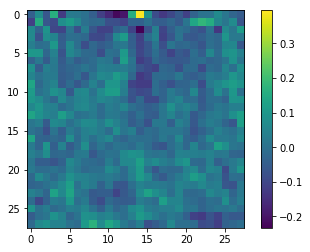

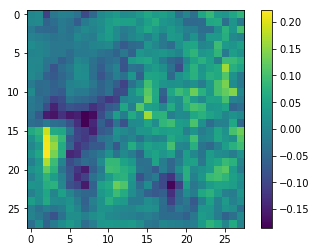

In [197]:
for c in range(10): 
    plt.imshow(model[best][-28**2:, c].reshape(28, 28))
    plt.colorbar()
    plt.show()

## Training Size Comparison

Finally, compare and contrast the behavior of training, in particular the absolute values
of training and validation accuracy and the role of regularization, in the two data regimes
(small vs large data set).

To compare to training and validation accuracy, we note that the training accuracy in the large dataset, while high, (eg. hit 88% classifcation rate) is slightly smaller than the on the validation set ( eg ~85% for our grid of lambdas). This difference between the training and validation accuracy for the smaller dataset, however, is significantly more. We're sitting at 100% classification on training but not even hitting 60% on the validation set. The role of regularization is also sigificantly different for the two training sets. In the large one, the regularization constant that performs best on the validation set is significantly smaller (given all other tuning parameters constant) than the regularization term from the smaller dataset. This is because as we get more data, we become more confident in our out of sample performance, and do not require too much regularization. In the smaller dataset setting, its much easier to overfit on the few samples we have, thus requiring more regularization. 

Also, one other notable difference is from the weight matrix and their visualizations. In the small dataset, the visualizations look much like the pictures (eg. we can easily see the jacket and the bag). However, in the large dataset, we can't see any image that resembles the items at all. This most likely arises from the fact that the classifier is overfitting to the images it has (which is very few), so it has no option other than to refer to the few pictures it has seen before. 